In [1]:
%matplotlib inline
#Importing important packages.
import pandas as pd, numpy as np, scipy, sklearn, re, requests
from matplotlib import pyplot as plt
import seaborn as sns
#Loading restaurant inspection data into a Pandas dataframe.
df = pd.read_csv("~/datascience/larestaurantdata/restaurant-and-market-health-inspections.csv")
#df['']

In [2]:
#Data Cleaning
#Convert all strings to lower case
for item in df.columns:
    try:
        df[item] = df[item].str.lower()
    except:
        pass
#Convert active/inactive to 1/0 
for item in ['program_status']:
    df[item].replace(to_replace='active', value=1, inplace=True)
    df[item].replace(to_replace='inactive',  value=0, inplace=True)
df['service_code'].replace(to_replace=401,value=0,inplace=True)
#Clean up ZIP codes by truncating additional data to keep 5-character ZIP code.
df['facility_zip'] = df['facility_zip'].apply(lambda s : s[:5])

#Function to extract info from pe_description
def info_extract(string):
    parts = re.findall('\w+',string)
    numberstuff = re.findall('\(.*\)',string)
    restype = ''
    done = 0
    risktype = ''
    for x in parts:
        try:
            int(x)
            if(done == 0):
                done=1
        except:
            if done ==0:
                restype+=x
                restype+=' '
            else:
                if(x!='seats' and x!='sf'):
                    risktype+=x
                    risktype+=' '
    answer = []
    if restype == 'food mkt retail ':
        answer.append(0)
    else:
        answer.append(1)
    if risktype == 'high risk ':
        answer.append(2)
    elif risktype == 'moderate risk ':
        answer.append(1)
    else:
        answer.append(0)
    if numberstuff[0] == '(0-30)':
        answer.append([0,30])
    elif numberstuff[0] == '(31-60)':
        answer.append([31,60])
    elif numberstuff[0] == '(61-150)':
        answer.append([61,150])
    elif numberstuff[0] == '(25-1,999 sf)':
        answer.append([25,1999])
    elif numberstuff[0] == '(151 + )':
        answer.append([151,1000])
    elif numberstuff[0] == '(2,000+ sf)':
        answer.append([2000,4000])
    answer.append(restype)
    answer.append(risktype)
    return [answer[0],answer[1],answer[2],answer[3],answer[4]]
#Applying info_extract
L = list(df['pe_description'].apply(info_extract).values)
cols= ['res_code','risk_code','size','res_type','risk_type']
df1 = pd.DataFrame(L,columns=cols)
df = pd.concat([df,df1],axis=1)
df['size'] = df['size'].apply(lambda x : (x[0]+x[1])/2)
#Removing redundant columns
df.drop(['facility_city','facility_state', 'pe_description','program_element_pe'],axis=1,inplace=True)
#Geocoding 
def latlong(address):
    params = {
        'address': address,
        'sensor': 'false',
        'region': 'united states'
    }
    GOOGLE_MAPS_API_URL = 'http://maps.googleapis.com/maps/api/geocode/json'
    # Do the request and get the response data
    req = requests.get(GOOGLE_MAPS_API_URL, params=params)
    res = req.json()

    # Use the first result
    try:
        result = res['results'][0]
    except:
        return [None,None]
    geodata = dict()
    geodata['lat'] = result['geometry']['location']['lat']
    geodata['lng'] = result['geometry']['location']['lng']
    geodata['address'] = result['formatted_address']
    print(result['formatted_address'])
    return([geodata['lat'],geodata['lng']])

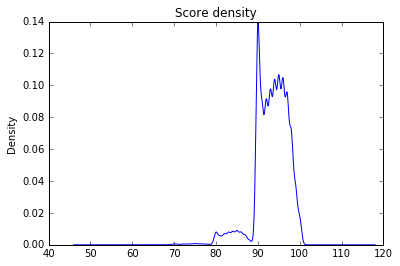

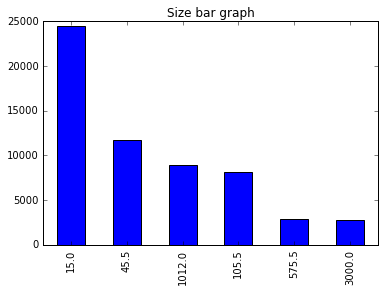

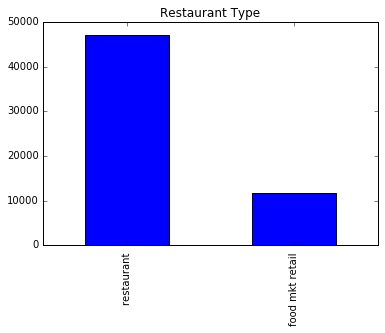

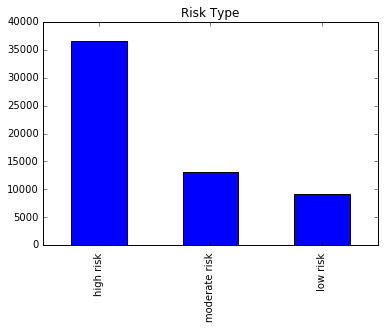

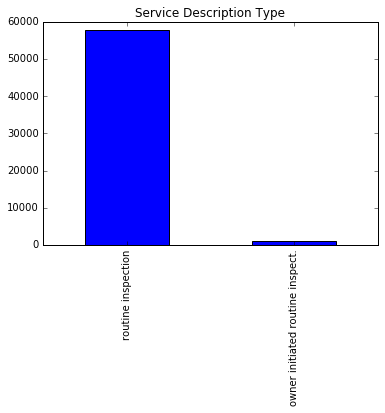

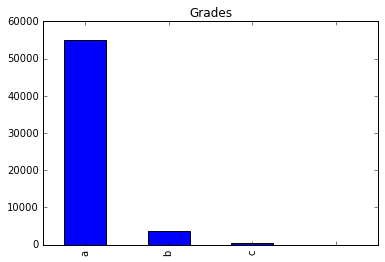

In [3]:
#Plot bar graphs for value counts and a density graph for score
df['score'].plot(kind = 'kde')
plt.title('Score density')
plt.show()
df['size'].value_counts().plot(kind='bar')
plt.title('Size bar graph')
plt.show()
df['res_type'].value_counts().plot(kind='bar')
plt.title('Restaurant Type')
plt.show()
df['risk_type'].value_counts().plot(kind='bar')
plt.title('Risk Type')
plt.show()
df['service_description'].value_counts().plot(kind='bar')
plt.title('Service Description Type')
plt.show()
df['grade'].value_counts().plot(kind='bar')
plt.title('Grades')
plt.show()

We run the k-means algorithm with 9 prospective clusters on a subset of our dataframe which we call dffeatures which comprises of the columns labeled by 'score','service_code','program_status','res_code' and'risk_type'. We need to convert risk_type to dummies that capture the risk type as 0/1

In [4]:
dffeatures = df[['score','service_code','program_status','res_code','risk_type']]
dffeatures = pd.get_dummies(dffeatures,columns=['risk_type']) 
from sklearn.cluster import KMeans
from sklearn import preprocessing
n_clusters = 9
kmeans=KMeans(n_clusters=9)
X = preprocessing.scale(dffeatures)
kmeans.fit(X)
dffeatures['cluster'] = kmeans.predict(X)

In [5]:
for i in range(0,n_clusters):
    temp = dffeatures[dffeatures['cluster']==i]
    print(temp['score'].mean(), temp['service_code'].mean(), temp['res_code'].mean(), temp['risk_type_high risk '].mean(), temp['risk_type_low risk '].mean(),temp.shape[0])

95.36280487804878 1.0 1.0 0.0 1.0 2296
93.41961545931248 1.0 1.0 1.0 0.0 25745
94.33164759116316 1.0 0.9334575459142933 0.0 0.0 11271
91.6117835122174 1.0 0.9095683946106417 0.9995432747202557 0.00045672527974423386 4379
92.76488395560041 0.0 0.9434914228052472 0.7709384460141272 0.03632694248234107 991
93.69915624090777 1.0 0.0 1.0 0.0 3437
95.50517568158624 1.0 0.0 0.0 1.0 6859
93.27696590118302 1.0 0.9519832985386222 0.0 0.0 1437
82.1001221001221 1.0 0.9470899470899471 0.9116809116809117 0.009361009361009361 2457


In [6]:
dffeatures = dffeatures.drop(['cluster'],axis=1)

Below, we run Logistic Regression, k-nearest neighbors, Random Forests and Naive Bayes on the data in dffeatures which have comparable predictive success when trying to predict res_code i.e. whether it's a restaurant or food market retail. 

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
steps = [('scaler',StandardScaler()),
        ('logistic_regression',LogisticRegression())]
pipeline = Pipeline(steps)
X = dffeatures.drop('res_code',axis=1).values
y = dffeatures['res_code'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

logreg_scaled = pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.877452229299


In [42]:
from sklearn.neighbors import KNeighborsClassifier
steps = [('scaler',StandardScaler()),
        ('knn',KNeighborsClassifier())]
pipeline = Pipeline(steps)
X = dffeatures.drop('res_code',axis=1).values
y = dffeatures['res_code'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

knn_scaled = pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.865392781316


In [43]:
from sklearn.naive_bayes import GaussianNB
steps1 = [('scaler',StandardScaler()),
        ('naive_bayes',GaussianNB())]
pipeline = Pipeline(steps1)
X = dffeatures.drop('res_code',axis=1).values
y = dffeatures['res_code'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

naive_scaled = pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.876772823779


In [52]:
from sklearn.ensemble import RandomForestClassifier
steps1 = [('scaler',StandardScaler()),
        ('random_forest',RandomForestClassifier())]
pipeline = Pipeline(steps1)
X = dffeatures.drop('res_code',axis=1).values
y = dffeatures['res_code'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

random_forest_scaled = pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.88033970276
